**Objectif :** L'objectif principal de ce notebook est de préparer et d'analyser les données issus des images satellites dans le but de suivre l'évolution de l'indice de végétation.

**Travail :**
A partir des données brutes nous voulons créer les rasters, puis calculer et analyser l'indice de végétation pour chaque parcelle agricole d'une zone géographique donnée.

Les différentes actions et transformations réalisées ici sont les suivantes :
    
1. A partir des images brutes .jp2 convertir en .tif
2. Préparer les features : calculer le NDVI pour chaque parcelle a chaque date
3. Enregistrer le résultat sous format d'image .tif
4. Superposer un .shapefile (représentant des polygones de zone d'intérêt) et les images .tif des NDVI
5. Calculer des statistiques pour chaque polygone (ie. parcelle) de l'image
6. Créer des séries temporelles (en fonction d'une caractéristique par exemple la médiane des NDVI)

In [1]:
student_folder = 'lebihan_ivan'

# Install packages

In [2]:
!pip install rasterstats
!pip install geopandas
!pip install wget
!apt install gdal-bin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=6e54f86657ef216fa05068d67688b0c59abd61fdf5c0407fb4d548340ce182b9
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Get:1 http://archive.ub

# Import packages

In [3]:
## Basics
import os
from os.path import isfile, isdir, join
from os import listdir
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import sys
import json
import plotly.express as px
from plotly.graph_objs import Scatter, Layout, Bar
from copy import deepcopy
import wget
import warnings
from shapely.errors import ShapelyDeprecationWarning

## Geo
import tifffile as tiff
from osgeo import gdal
from rasterstats import zonal_stats
import geopandas as gpd


# Import data

---

🚨 ❗L'importation des données prend environ 15 minutes ❗

---

In [4]:
url1 = 'https://ecoles-projets-shared-files.hupi.io/satellite/DSC.zip'
wget.download(url1)

'DSC.zip'

In [5]:
pwd

'/content'

In [6]:
!unzip DSC.zip

Archive:  DSC.zip
   creating: DSC/
  inflating: DSC/save_to_raster.py   
   creating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/
  inflating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/INSPIRE.xml  
  inflating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/manifest.safe  
  inflating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/MTD_MSIL2A.xml  
   creating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/AUX_DATA/
   creating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/DATASTRIP/
   creating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/DATASTRIP/DS_MTI__20181117T121932_S20181117T105429/
  inflating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/DATASTRIP/DS_MTI__20181117T121932_S20181117T105429/MTD_DS.xml  
   creating: DSC/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932

In [7]:
ls -ltr ./DSC

total 20
-rw-r--r-- 1 root root 1095 Dec 24  2021 save_to_raster.py
drwxr-xr-x 6 root root 4096 Dec 24  2021 S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE/
drwxr-xr-x 6 root root 4096 Dec 24  2021 S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.SAFE/
drwxr-xr-x 6 root root 4096 Dec 24  2021 S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.SAFE/
drwxr-xr-x 2 root root 4096 Dec 24  2021 shapefile/


# Function definition
## Conversion d'un objet en une image

- Input : une matrice.image de type `array`
- Output : une image sous format `.tif`
- Option : ajuster selon les propriétés d'une image de référence (une projection, le système de géoréférence)

In [8]:
from osgeo import gdal,gdal_array,osr,ogr

def array2raster(newRasterfn, dataset, array, dtype):
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == 'Byte':
        GDT_dtype = gdal.GDT_Byte
    elif dtype == 'Float32':
        GDT_dtype = gdal.GDT_Float32
    else:
        print('Not supported data type.')
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

# Path definition

In [9]:
!mkdir ./etudiants/
!mkdir ./etudiants/$student_folder/
!mkdir ./etudiants/$student_folder/USE_CASE_1/
!mkdir ./etudiants/$student_folder/USE_CASE_1/output/
!mkdir ./etudiants/$student_folder/USE_CASE_1/NDVI/
!mkdir ./etudiants/$student_folder/USE_CASE_1/shp_stat/
!mkdir ./etudiants/$student_folder/USE_CASE_1/temporal_stats/
!mkdir ./etudiants/$student_folder/USE_CASE_1/cleaned_stats/
!mkdir ./etudiants/$student_folder/USE_CASE_1/reconstructed_stats/
!mkdir ./etudiants/$student_folder/USE_CASE_1/interpolated_stats/

In [10]:
# Test
path = './DSC/'
output_path = './etudiants/'+student_folder+'/USE_CASE_1/output/'
ndvi_output_path = './etudiants/'+student_folder+'/USE_CASE_1/NDVI/'
stat_path = './etudiants/'+student_folder+'/USE_CASE_1/shp_stat/'
temporal_stats_path = './etudiants/'+student_folder+'/USE_CASE_1/temporal_stats/'

# IMPOSSIBLE DE RUN LE CODE A PARTIR DE `ETAPE n°1` JUSQU'A `ETAPE n°5` INCLUS SI PAS LE DOSSIER `./DSC`



# Etape n°1 : convertir les images brutes en `.tif`

**Objectif :** prétraiter les données. Depuis un format compressé `.jp2` changer le format en `.tif`, en utilisant les commandes de la librairie `gdal`.

**Travail :** on va prétraiter les images satellites de résolution de 10 mètres.

**Les fonctions de `gdal` :**
- gdalwarp : permet de reprojecter une image
- gdal_translate : permet de convertir des données raster sous différents formats.

Exemple :
```
!/bin/bash
gdalwarp -lr 10 10 $1 $2
gdal_translate -unscale -ot Byte $2 $3
```

In [11]:
# On filtre les données des images satellites, pour éviter de récolter des fichiers supplémentaires .txt par exemple
list_imgs = [name for name in listdir(path) if (isdir(join(path,name)) and 'SAFE' in name)]
print(list_imgs)

['S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.SAFE', 'S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.SAFE', 'S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE']


---

🚨 ❗Cette 1ère étape prend environ 10 minutes ❗

---

In [12]:
def transform_jp2_to_tiff():
  ind = 0
  for img in list_imgs:

      ######       Etape 1 : transformer en .tif     ######

      img_path = join(path,img)

      # obtenir le dossier contenant les differentes images par bandes
      granule_path = join(img_path, 'GRANULE') # nom de dossier Granule fixe
      list_subdir = [name for name in listdir(granule_path) if isdir(join(granule_path, name))][0]
      band_path = join(granule_path, list_subdir, 'IMG_DATA')
      list_band_dir = [name for name in listdir(band_path) if isdir(join(band_path, name))]

      # obtenir la bande de résolution de 10m
      dir_10m = join(band_path, 'R10m')

      # filtrer les fichiers .xml ou tout fichier autre que .jp2 du dossier
      band_list = [name for name in listdir(join(dir_10m)) if isfile(join(dir_10m, name))
                  and len(name.split('.'))==2 and name.split('.')[1]=='jp2']

      # créer un dictionnaire avec le chemin de chaque bandes
      dict_bands = {}
      for band in band_list:
          tmp_path = join(dir_10m, band)

          # extension du nom de output est different de input : on recupere le nom et ajoute .tif
          name_band = band.split('.')[0]+'.tif'
          band_output_path = join(output_path, name_band)

          if band.split('_')[-2] == 'B04':
              dict_bands['red'] = band_output_path
          elif band.split('_')[-2] == 'B08':
              dict_bands['nir'] = band_output_path

          # convertir les données raster en format '.tif'
          # 'unscale' permet de ne pas perdre d'information spectrale
          subprocess.call(['gdal_translate', '-unscale', tmp_path, band_output_path])

  return(band_list)

band_list = transform_jp2_to_tiff()

In [13]:
ls ./etudiants/$student_folder/USE_CASE_1/output/

T31TCJ_20181117T105321_AOT_10m.tif  T31TCJ_20181127T105401_B08_10m.tif
T31TCJ_20181117T105321_B02_10m.tif  T31TCJ_20181127T105401_TCI_10m.tif
T31TCJ_20181117T105321_B03_10m.tif  T31TCJ_20181127T105401_WVP_10m.tif
T31TCJ_20181117T105321_B04_10m.tif  T31TCJ_20190103T104431_AOT_10m.tif
T31TCJ_20181117T105321_B08_10m.tif  T31TCJ_20190103T104431_B02_10m.tif
T31TCJ_20181117T105321_TCI_10m.tif  T31TCJ_20190103T104431_B03_10m.tif
T31TCJ_20181117T105321_WVP_10m.tif  T31TCJ_20190103T104431_B04_10m.tif
T31TCJ_20181127T105401_AOT_10m.tif  T31TCJ_20190103T104431_B08_10m.tif
T31TCJ_20181127T105401_B02_10m.tif  T31TCJ_20190103T104431_TCI_10m.tif
T31TCJ_20181127T105401_B03_10m.tif  T31TCJ_20190103T104431_WVP_10m.tif
T31TCJ_20181127T105401_B04_10m.tif


(10980, 10980)


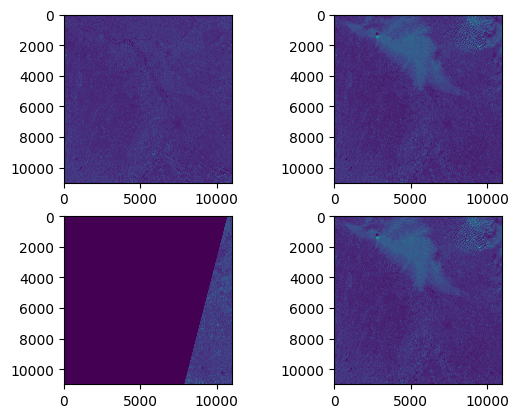

In [14]:
bande_bleue = 'T31TCJ_20181117T105321_B08_10m.tif'
bande_verte = 'T31TCJ_20181127T105401_B08_10m.tif'
bande_rouge = 'T31TCJ_20190103T104431_B08_10m.tif'
bande_infra = 'T31TCJ_20181127T105401_B08_10m.tif'

print(tiff.imread(output_path + bande_bleue).shape)

fig, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(2, 2)

ax1.imshow(tiff.imread(output_path + bande_bleue))

ax2.imshow(tiff.imread(output_path + bande_verte))

ax3.imshow(tiff.imread(output_path + bande_rouge))

ax4.imshow(tiff.imread(output_path + bande_infra))

# Etape n°2 : extraire les caractéristiques

Il y a deux méthodes principales pour cela :
- Feature extraction : il faut la connaissance métier.
- Feature extraction avec ML : sans connaissances métiers.

Ici, nous allons tout d'abord travailler à partir d'une base de connaissance métier.

Notre objectif sera de prédire un indice de végétation, indiquant la nature d'une parcelle agricole.

**Indicateur métier :**

Définition [Indice de végétation] = c'est un indice entre 0 et 1 (ou -1 et 1) plus c'est proche de 1, plus la végétation est dense, importante. Cet indicateur est utilisé pour suivre les cultures d'hiver et d'été.

$$ NDVI = \frac{NIR - RED}{NIR + RED} $$

où $NIR$ est la réflexion mesurée dans le canal proche infrarouge (near infrared) et $RED$ est celle mesurée dans le canal rouge.

In [15]:
ls -altr ./etudiants/$student_folder/USE_CASE_1/

total 36
drwxr-xr-x 3 root root 4096 Apr 27 18:32 ../
drwxr-xr-x 2 root root 4096 Apr 27 18:32 NDVI/
drwxr-xr-x 2 root root 4096 Apr 27 18:32 shp_stat/
drwxr-xr-x 2 root root 4096 Apr 27 18:32 temporal_stats/
drwxr-xr-x 2 root root 4096 Apr 27 18:32 cleaned_stats/
drwxr-xr-x 2 root root 4096 Apr 27 18:32 reconstructed_stats/
drwxr-xr-x 2 root root 4096 Apr 27 18:32 interpolated_stats/
drwxr-xr-x 9 root root 4096 Apr 27 18:32 ./
drwxr-xr-x 2 root root 4096 Apr 27 18:37 output/


<ipython-input-16-71d279d769bd>:44: RuntimeWarning: invalid value encountered in divide
  ndvi = np.divide((nir_band - red_band), (nir_band + red_band)) # + 0.0001 pour rendre le diviseur non nul


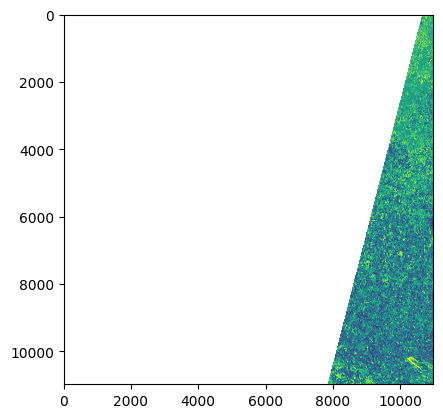

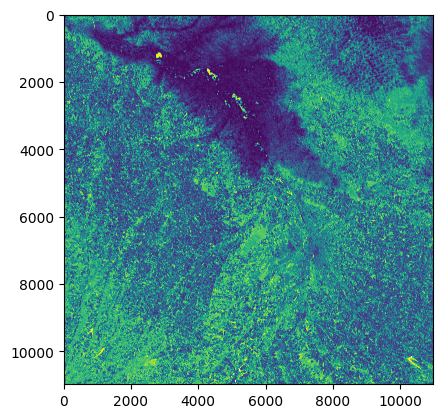

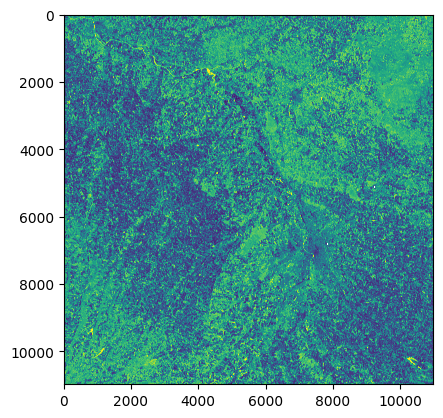

In [16]:
def extract_ndvi_measures():
  ind = 0
  for img in list_imgs:

      ######       Etape 1 : transformer en .tif     ######

      img_path = join(path,img)

      # obtenir le dossier contenant les differentes images par bandes
      granule_path = join(img_path, 'GRANULE') # nom de dossier Granule fixe
      list_subdir = [name for name in listdir(granule_path) if isdir(join(granule_path, name))][0]
      band_path = join(granule_path, list_subdir, 'IMG_DATA')
      list_band_dir = [name for name in listdir(band_path) if isdir(join(band_path, name))]

      # obtenir la bande de résolution de 10m
      dir_10m = join(band_path, 'R10m')

      # filtrer les fichiers .xml ou tout fichier autre que .jp2 du dossier
      band_list = [name for name in listdir(join(dir_10m)) if isfile(join(dir_10m, name))
                  and len(name.split('.'))==2 and name.split('.')[1]=='jp2']

      # créer un dictionnaire avec le chemin de chaque bandes
      dict_bands = {}
      for band in band_list:
          tmp_path = join(dir_10m, band)

          # extension du nom de output est different de input : on recupere le nom et ajoute .tif
          name_band = band.split('.')[0]+'.tif'
          band_output_path = join(output_path, name_band)

          if band.split('_')[-2] == 'B04':
              dict_bands['red'] = band_output_path
          elif band.split('_')[-2] == 'B08':
              dict_bands['nir'] = band_output_path

          # convertir les données raster en format '.tif'
          # 'unscale' permet de ne pas perdre d'information spectrale
          # subprocess.call(['gdal_translate', '-unscale', tmp_path, band_output_path])


      ####          Etape 2 Features extraction     #####
      nir_band = tiff.imread(dict_bands['nir'])
      red_band = tiff.imread(dict_bands['red'])
      ndvi = np.divide((nir_band - red_band), (nir_band + red_band)) # + 0.0001 pour rendre le diviseur non nul
      ndvi[ndvi>1]=1
      plt.figure(ind)
      plt.imshow(ndvi)
      plt.show()
      ind+=1

extract_ndvi_measures()

3 images différentes :
- 1 image avec couverture nuageuse
- 1 image avec une bande non aquise
- 1 image avec les bonnes valeurs

# Etape n°3 : sauvegarder le résultat sous format `.tif` à l'aide de la fonction `array2raster`

In [17]:
def save_ndvi_imgs():
  ind = 0
  for img in list_imgs:

      ######       Etape 1 : transformer en .tif     ######

      img_path = join(path,img)

      # obtenir le dossier contenant les differentes images par bandes
      granule_path = join(img_path, 'GRANULE') # nom de dossier Granule fixe
      list_subdir = [name for name in listdir(granule_path) if isdir(join(granule_path, name))][0]
      band_path = join(granule_path, list_subdir, 'IMG_DATA')
      list_band_dir = [name for name in listdir(band_path) if isdir(join(band_path, name))]

      # obtenir la bande de résolution de 10m
      dir_10m = join(band_path, 'R10m')

      # filtrer les fichiers .xml ou tout fichier autre que .jp2 du dossier
      band_list = [name for name in listdir(join(dir_10m)) if isfile(join(dir_10m, name))
                  and len(name.split('.'))==2 and name.split('.')[1]=='jp2']

      # créer un dictionnaire avec le chemin de chaque bandes
      dict_bands = {}
      for band in band_list:
          tmp_path = join(dir_10m, band)

          # extension du nom de output est different de input : on recupere le nom et ajoute .tif
          name_band = band.split('.')[0]+'.tif'
          band_output_path = join(output_path, name_band)

          if band.split('_')[-2] == 'B04':
              dict_bands['red'] = band_output_path
          elif band.split('_')[-2] == 'B08':
              dict_bands['nir'] = band_output_path

          # convertir les données raster en format '.tif'
          # 'unscale' permet de ne pas perdre d'information spectrale
          # subprocess.call(['gdal_translate', '-unscale', tmp_path, band_output_path])


      ####          Etape 2 : extraire le ndvi    #####
      nir_band = tiff.imread(dict_bands['nir'])
      red_band = tiff.imread(dict_bands['red'])
      ndvi = np.divide((nir_band - red_band), (nir_band + red_band)) # + 0.0001 pour rendre le diviseur non nul
      ndvi[ndvi>1]=1
      # plt.figure(ind)
      # plt.imshow(ndvi)
      # plt.show()
      # ind+=1

      #####       Etape 3 : enregistrer le resultat sous format .tif  ######
      name_f = img.split('.')[0]+'.tif'
      ndvi_output_raster = join(ndvi_output_path, name_f)

      # le ndvi fait 10m*10m
      dataset = gdal.Open(dict_bands['nir'])

      # sauvegarde
      array2raster(ndvi_output_raster, dataset, ndvi, 'Float32')

save_ndvi_imgs()

<ipython-input-17-c548adf9116d>:44: RuntimeWarning: invalid value encountered in divide
  ndvi = np.divide((nir_band - red_band), (nir_band + red_band)) # + 0.0001 pour rendre le diviseur non nul


In [18]:
ls ./etudiants/$student_folder/USE_CASE_1/NDVI/

S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.tif
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.tif
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.tif


# Conclusion temporaire :

Nous avons pour chaque image satellite, calculé l'indice de végétation associé. On a donc à chaque pixel donné, la valeur de l'indicateur NDVI.

Commençons par découvrir et analyser cet indicateur sur des parcelles agricoles pré-définies. En effet, nous avons à notre disposition un fichier sous format de .shapefile, représentant des polygones définissant des parcelles agricoles spécifiques.

L'objectif de la découverte des données est de calculer des statistiques de l'indice NDVI sur ces parcelles agricoles.

# Etape n°4 : calculer des statistiques

A partir du fichier `.shp`, on va calculer sur chaque polygone des statistiques de l'indice NDVI :
- la moyenne sur les ? jours étudiées
- la médiane
- le minimum et le maximum

Pour cela on va utiliser la librairie `rasterstats` qui permet à partir d'un raster et d'un shapefile calculer des statistiques.


In [ ]:
ndvi_list = [name for name in listdir(ndvi_output_path) if isfile(join(ndvi_output_path, name))]
print(np.array(ndvi_list))

['S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.tif'
 'S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.tif'
 'S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.tif']


In [ ]:
!ls ./DSC/shapefile

T31TCJ_MIS_BTH.cpg  T31TCJ_MIS_BTH.dbf	T31TCJ_MIS_BTH.prj  T31TCJ_MIS_BTH.shp	T31TCJ_MIS_BTH.shx


In [ ]:
def compute_statistics_from_ndvi():
  warnings.filterwarnings('ignore', category=ShapelyDeprecationWarning)
  shp_file = './DSC/shapefile/T31TCJ_MIS_BTH.shp'
  for ndvi_img in ndvi_list:
      ndvi_img_path = join(ndvi_output_path, ndvi_img)
      zone_f = zonal_stats(shp_file, ndvi_img_path,
                          stats=['min', 'max', 'median', 'mean', 'std'],
                          nodata=np.nan,
                          copy_properties=True,
                          geojson_out=True)
      # chaque dictionnaire est associe a une parcelle

      # sauvegarde en format geo dataframe
      geostats = gpd.GeoDataFrame.from_features(zone_f)
      geostats.crs = 'epsg:32631' # definir la projection
      output_file = join(stat_path, ndvi_img.split('.')[0]+'.shp')
      geostats.to_file(output_file)

compute_statistics_from_ndvi()

In [ ]:
ls ./etudiants/$student_folder/USE_CASE_1/shp_stat/

S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.cpg
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.dbf
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.prj
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shp
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shx
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.cpg
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.dbf
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.prj
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shp
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shx
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.cpg
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.dbf
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.prj
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shp
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shx


---

Exemple de statistiques le 17-11-2018 sur toutes les zones géographiques visées :

---

In [ ]:
url = './etudiants/'+student_folder+'/USE_CASE_1/shp_stat/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shp'
geostats_test = gpd.read_file(url)

In [ ]:
geostats_test.head()

,fid,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,area,min,max,mean,std,median,geometry
0,7163652.0,3254775,17.93,MIS,2,None,None,179308.512395,0.121659,0.770717,0.254383,0.115304,0.216000,"POLYGON ((319536.462 4867103.915, 319867.231 4..."
1,7913374.0,12244663,5.72,MIS,2,None,None,57181.902327,0.072581,0.650523,0.179258,0.085530,0.146260,"POLYGON ((329673.499 4850161.704, 329665.546 4..."
2,7804707.0,11239602,5.48,MIS,2,None,None,54755.127837,0.144475,0.744256,0.281337,0.127953,0.229947,"POLYGON ((399215.319 4829801.046, 399205.640 4..."
3,7047346.0,3148886,22.76,MIS,2,None,None,227436.221611,0.032086,0.654779,0.103146,0.089812,0.077619,"POLYGON ((361120.600 4850919.265, 361120.585 4..."
4,7829266.0,8481604,6.04,MIS,2,None,None,60333.785977,0.134348,0.701759,0.244950,0.104065,0.203579,"POLYGON ((403011.425 4837089.559, 403003.095 4..."


In [ ]:
geostats_test.columns

Index(['fid', 'ID_PARCEL', 'SURF_PARC', 'CODE_CULTU', 'CODE_GROUP',
       'CULTURE_D1', 'CULTURE_D2', 'area', 'min', 'max', 'mean', 'std',
       'median', 'geometry'],
      dtype='object')

<Axes: >

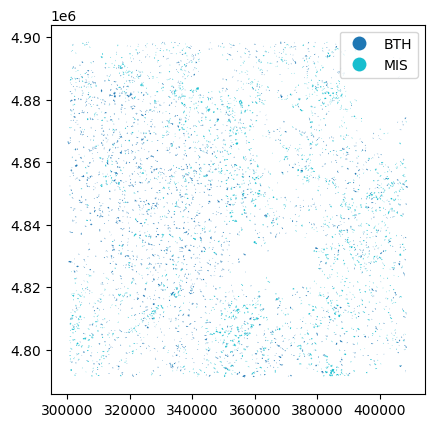

In [ ]:
geostats_test.plot(column="CODE_CULTU", legend=True)

Affichage du format vecteurs (parcelles) fonction du code de culture

# Etape n°5 : créer une série temporelle

On va traiter chaque mesure d'une parcelle, comme une série temporelle. L'objectif sera de faire des statistiques sur ces séries temporelles.

In [ ]:
ls ./etudiants/$student_folder/USE_CASE_1/shp_stat/

S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.cpg
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.dbf
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.prj
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shp
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shx
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.cpg
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.dbf
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.prj
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shp
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shx
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.cpg
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.dbf
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.prj
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shp
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shx


In [ ]:
def construct_temporal_stats(stat_path,output_path):
    vi_list = ['ndvi']
    all_stats = ['mean','median','std','min','max']
    stat_list = ['median']
    list_imgs = [name for name in listdir(stat_path) if isfile(join(stat_path,name)) and name.split('.')[1]=='shp']
    # on ordonne par date
    list_imgs = sorted(list_imgs, key=lambda x: int(x.split('_')[2][0:8]))

    # en boucle sur chaque image
    for vi in vi_list:
        for stat in stat_list:
            cnt = 0
            for img in list_imgs:
                print ('CONSTRUCTING TEMPORAL STATS FOR %s and %s and %s'%(vi,stat,img))
                date = img.split('_')[2][0:8]
                shp_path = join(stat_path,img)
                gdf = gpd.read_file(shp_path)

                if cnt == 0:
                    new_gdf = gdf.copy()
                    new_gdf[date] = gdf[stat]
                    new_gdf.drop(all_stats,axis=1,inplace=True)
                else:
                    new_gdf[date] = gdf[stat]
                cnt+=1
            shp_output_path = join(output_path,'T31TCJ_'+vi+'_'+stat+'.shp')
            new_gdf.to_file(shp_output_path)

__name__ = '__main__'
if __name__ == '__main__':
    construct_temporal_stats(stat_path, temporal_stats_path)

CONSTRUCTING TEMPORAL STATS FOR ndvi and median and S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shp
CONSTRUCTING TEMPORAL STATS FOR ndvi and median and S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shp
CONSTRUCTING TEMPORAL STATS FOR ndvi and median and S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shp


In [ ]:
ls ./etudiants/$student_folder/USE_CASE_1/temporal_stats/

T31TCJ_ndvi_median.cpg  T31TCJ_ndvi_median.prj  T31TCJ_ndvi_median.shx
T31TCJ_ndvi_median.dbf  T31TCJ_ndvi_median.shp


In [ ]:
ls USE_CASE_1_correction/temporal_stats_prof/

ls: cannot access 'USE_CASE_1_correction/temporal_stats_prof/': No such file or directory


In [ ]:
url = './etudiants/lebihan_ivan/USE_CASE_1/temporal_stats/T31TCJ_ndvi_median.shp'
time_serie = gpd.read_file(url)

In [ ]:
time_serie.head()

,fid,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,area,20181117,20181127,20190103,geometry
0,7163652.0,3254775,17.93,MIS,2,None,None,179308.512395,0.216000,0.158361,NaN,"POLYGON ((319536.462 4867103.915, 319867.231 4..."
1,7913374.0,12244663,5.72,MIS,2,None,None,57181.902327,0.146260,0.153494,NaN,"POLYGON ((329673.499 4850161.704, 329665.546 4..."
2,7804707.0,11239602,5.48,MIS,2,None,None,54755.127837,0.229947,0.268489,0.355649,"POLYGON ((399215.319 4829801.046, 399205.640 4..."
3,7047346.0,3148886,22.76,MIS,2,None,None,227436.221611,0.077619,0.080833,NaN,"POLYGON ((361120.600 4850919.265, 361120.585 4..."
4,7829266.0,8481604,6.04,MIS,2,None,None,60333.785977,0.203579,0.237619,0.242820,"POLYGON ((403011.425 4837089.559, 403003.095 4..."


--------------------------------------------